In [3]:
import os
import tempfile
import warnings
from os.path import join as pjoin

import dask
import dask.dataframe as dd
import dask_geopandas as dgpd
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from scipy.fft import dst
import tqdm
import xarray as xr
from dask.diagnostics import ProgressBar
from rasterio.crs import CRS

from raster_tools import Raster, Vector, open_vectors, clipping, zonal
from raster_tools.dtypes import F32, U8, U16

import matplotlib.pyplot as plt

# change pandas max col display
pd.set_option('display.max_columns', 500)

# Location for temporary storage
TMP_LOC = "/home/jake/FireLab/Project/data/temp/"
DATA_LOC = "/home/jake/FireLab/Project/data/"

STATE = "OR"

# Location of clipped DEM files
DEM_DATA_DIR = pjoin(TMP_LOC, "dem_data")

# location of feature data files
FEATURE_DIR = pjoin(DATA_LOC, "FeatureData")
EDNA_DIR = pjoin(DATA_LOC, "terrain")
MTBS_DIR = pjoin(DATA_LOC, "MTBS_Data")

mtbs_df_path = pjoin(TMP_LOC, f"{STATE}_mtbs.parquet/")
mtbs_df_parquet_path = pjoin(TMP_LOC, f"{STATE}_mtbs_new.parquet")
mtbs_df_temp_path = pjoin(TMP_LOC, f"{STATE}_mtbs_temp.parquet/")
checkpoint_1_path = pjoin(TMP_LOC, "check1")
checkpoint_2_path = pjoin(TMP_LOC, "check2")

PATHS = {
    "states": pjoin(EDNA_DIR, "state_borders/cb_2018_us_state_5m.shp"),
    "dem": pjoin(EDNA_DIR, "us_orig_dem/us_orig_dem/orig_dem/hdr.adf"),
    "dem_slope": pjoin(EDNA_DIR, "us_slope/us_slope/slope/hdr.adf"),
    "dem_aspect": pjoin(EDNA_DIR, "us_aspect/aspect/hdr.adf"),
    "dem_flow_acc": pjoin(EDNA_DIR, "us_flow_acc/us_flow_acc/flow_acc/hdr.adf"),
    "gm_srad": pjoin(FEATURE_DIR, "gridmet/srad_1986_2020_weekly.nc"),
    "gm_vpd": pjoin(FEATURE_DIR, "gridmet/vpd_1986_2020_weekly.nc"),
    "aw_mat": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MAT.tif"),
    "aw_mcmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MCMT.tif"),
    "aw_mwmt": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_MWMT.tif"),
    "aw_td": pjoin(FEATURE_DIR, "adaptwest/Normal_1991_2020_TD.tif"),
    "dm_tmax": pjoin(FEATURE_DIR, "daymet/tmax_1986_2020.nc"),
    "dm_tmin": pjoin(FEATURE_DIR, "daymet/tmin_1986_2020.nc"),
    "biomass_afg": pjoin(
        FEATURE_DIR, "biomass/biomass_afg_1986_2020_{}.nc".format(STATE)
    ),
    "biomass_pfg": pjoin(
        FEATURE_DIR, "biomass/biomass_pfg_1986_2020_{}.nc".format(STATE)
    ),
    "landfire_fvt": pjoin(
        FEATURE_DIR, "landfire/LF2020_FVT_200_CONUS/Tif/LC20_FVT_200.tif"
    ),
    "landfire_fbfm40": pjoin(
        FEATURE_DIR, "landfire/LF2020_FBFM40_200_CONUS/Tif/LC20_F40_200.tif"
    ),
    "ndvi": pjoin(FEATURE_DIR, "ndvi/access/weekly/ndvi_1986_2020_weekavg.nc"),
    "mtbs_root": pjoin(MTBS_DIR, "MTBS_BSmosaics/"),
    "mtbs_perim": pjoin(MTBS_DIR, "mtbs_perimeter_data/mtbs_perims_DD.shp"),
}
YEARS = list(range(2016, 2021))
GM_KEYS = list(filter(lambda x: x.startswith("gm_"), PATHS))
AW_KEYS = list(filter(lambda x: x.startswith("aw_"), PATHS))
DM_KEYS = list(filter(lambda x: x.startswith("dm_"), PATHS))
BIOMASS_KEYS = list(filter(lambda x: x.startswith("biomass_"), PATHS))
LANDFIRE_KEYS = list(filter(lambda x: x.startswith("landfire_"), PATHS))
NDVI_KEYS = list(filter(lambda x: x.startswith("ndvi"), PATHS))
DEM_KEYS = list(filter(lambda x: x.startswith("dem"), PATHS))

---

In [ ]:
mtbs_df_2018_2020 = dgpd.read_parquet(checkpoint_2_path)

In [ ]:
len(mtbs_df_2018_2020)

In [ ]:
mtbs_df_2018_2020_computed = mtbs_df_2018_2020.compute()

In [ ]:
len(mtbs_df_2018_2020_computed.geometry.unique())

In [ ]:
# find the count of unique date geometry pairs
mtbs_df_2018_2020_computed.groupby(["ig_date", "geometry"]).size().reset_index().shape

#### MTBS DATASET ADD UID AND EVENT ID

In [ ]:
# load mtbs perimeters
print("Loading MTBS perimeters")
mtbs_perim = gpd.read_file(PATHS["mtbs_perim"])
mtbs_perim['Ig_Date'] = pd.to_datetime(mtbs_perim['Ig_Date'])
mtbs_perim.columns

# extract only the columns we need (Event_ID where startswith OR, Ig_Date, and geometry)
mtbs_perim = mtbs_perim[["Event_ID", "Ig_Date", "geometry"]]
mtbs_perim = mtbs_perim[mtbs_perim.Event_ID.str.startswith("OR")]
# drop rows where Ig_Date before 1986 or after 2020
mtbs_perim = mtbs_perim[mtbs_perim.Ig_Date.dt.year.between(2018, 2020)]
mtbs_perim.reset_index(drop=True, inplace=True)
len(mtbs_perim)

In [ ]:
# convert the geometry in mtbs_dataset to lat lon
# mtbs_dask_df = mtbs_dask_df.to_crs(epsg=4326)
mtbs_perim = mtbs_perim.to_crs(mtbs_df_2018_2020.crs)
# mtbs_dataset = mtbs_dataset.to_crs(epsg=4326)

In [ ]:
def spatial_join(partition, mtbs_perim):
    # Convert the Dask partition to a GeoDataFrame
    gdf = gpd.GeoDataFrame(partition, geometry='geometry', crs=mtbs_perim.crs)

    # Perform the spatial join
    joined = gpd.sjoin(gdf, mtbs_perim, how="inner", predicate="intersects")

    # Filter by date if needed
    joined = joined[joined['ig_date'] == joined['Ig_Date']]
    # print(joined)

    return joined

result = mtbs_df_2018_2020.map_partitions(spatial_join, mtbs_perim, align_dataframes=False)
print(len(result))

In [ ]:
with ProgressBar():
    final_result = result.compute()

In [ ]:
final_result

In [ ]:
# TODO: compare final_results and mtbs_dataset to see what is missing from final_results after the spatial join

In [ ]:
final_result.drop(columns=['index_right', 'Ig_Date'], inplace=True)

In [ ]:
# drop null values
final_result.dropna(inplace=True)
# adds unique id to each pixel
final_result.reset_index(inplace=True)
final_result['index'] = final_result.index
# rename index to unique_id
final_result.rename(columns={'index': 'unique_id'}, inplace=True)
final_result

In [ ]:
# plot a fire topo map

eventID = 'OR4380511789220200816'

fire = final_result[final_result.Event_ID == eventID]

col = 'dem'

fire.plot(column=col, s=1)

In [ ]:
# write final_result to dask so we can write to parquet
# final_result = dd.from_pandas(final_result, npartitions=100)

In [ ]:
with ProgressBar():
    final_result.to_parquet(mtbs_df_parquet_path)

In [ ]:
final_result = None

In [4]:
# read and check
mtbs_dataset_final = dgpd.read_parquet(mtbs_df_parquet_path)
with ProgressBar():
    mtbs_final_computed = mtbs_dataset_final.compute()

[########################################] | 100% Completed | 35.15 s


In [6]:
mtbs_final_computed

,unique_id,mtbs,geometry,state,ig_date,dem,dem_slope,dem_aspect,dem_flow_acc,Event_ID
0,0,1,POINT (-1825230.000 2475090.000),OR,2018-04-27,1869.0,18.211313,176.623978,1.0,OR4327211882920180427
1,1,2,POINT (-1825200.000 2475090.000),OR,2018-04-27,1345.0,11.628568,234.196259,16.0,OR4327211882920180427
2,2,1,POINT (-1825170.000 2475090.000),OR,2018-04-27,1433.0,4.674816,195.418152,7.0,OR4327211882920180427
3,3,1,POINT (-1825260.000 2475060.000),OR,2018-04-27,1647.0,1.859062,3.434479,0.0,OR4327211882920180427
4,4,2,POINT (-1825230.000 2475060.000),OR,2018-04-27,1250.0,0.000000,-1.000000,11.0,OR4327211882920180427
...,...,...,...,...,...,...,...,...,...,...
28327432,28327432,1,POINT (-1697340.000 2447820.000),OR,2020-11-05,1461.0,8.161068,105.121094,11.0,OR4333011722220201105
28327433,28327433,1,POINT (-1697490.000 2447790.000),OR,2020-11-05,1477.0,6.338682,134.559052,2.0,OR4333011722220201105
28327434,28327434,1,POINT (-1697460.000 2447790.000),OR,2020-11-05,1474.0,5.296444,148.826309,8.0,OR4333011722220201105
28327435,28327435,1,POINT (-1697430.000 2447790.000),OR,2020-11-05,1472.0,4.947824,132.493271,8.0,OR4333011722220201105


<Axes: >

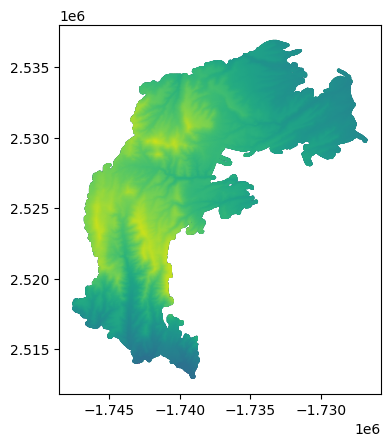

In [5]:
# plot a fire topo map

eventID = 'OR4380511789220200816'

fire = mtbs_final_computed[mtbs_final_computed.Event_ID == eventID]

col = 'dem'

fire.plot(column=col, s=1)

In [ ]:
mtbs_dataset_2020_08_16 = mtbs_dataset[(mtbs_dataset.year == 2020) & (mtbs_dataset.ig_date.dt.month == 8) & (mtbs_dataset.ig_date.dt.day == 16)]
mtbs_dataset_2020_08_16

In [ ]:
mtbs_dataset_2020_08_16.plot(column=col, s=1)